In [1]:
import pandas as pd
import numpy as np
import lanelet2
import matplotlib.pyplot as plt

from av_goal_recognition.base import get_scenario_config_dir,get_data_dir
from av_goal_recognition.goal_recognition import TrainedDecisionTrees
from av_goal_recognition.data_processing import get_dataset
from av_goal_recognition.scenario import Scenario

plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)

In [2]:
scenario_name = 'heckstrasse'
dataset_name = 'test'
dataset = get_dataset(scenario_name, dataset_name)
scenario = Scenario.load(get_scenario_config_dir() + scenario_name + '.json')

model = TrainedDecisionTrees.load(scenario_name)
unique_samples = model.batch_goal_probabilities(dataset)
unique_samples['model_correct'] = (unique_samples['model_prediction']
                                   == unique_samples['true_goal'])
accuracy = unique_samples.model_correct.mean()

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!
Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	

In [3]:
accuracy

0.9728317659352143

In [4]:
unique_samples.columns

Index(['episode', 'agent_id', 'frame_id', 'true_goal', 'true_goal_type',
       'fraction_observed', 'model_prediction', 'predicted_goal_type',
       'model_probs', 'max_probs', 'min_probs', 'model_entropy',
       'model_entropy_norm', 'model_correct'],
      dtype='object')

In [5]:
unique_samples.model_prediction.unique()

array([1, 0, 2])

In [6]:
unique_samples.groupby(['true_goal', 'true_goal_type']).model_correct.mean()

true_goal  true_goal_type
0          straight-on       0.991543
           turn-right        0.613636
1          straight-on       0.995722
           turn-left         0.872727
2          turn-left         0.984190
           turn-right        0.909091
Name: model_correct, dtype: float64

In [7]:
unique_goals = unique_samples[['true_goal', 'true_goal_type']].drop_duplicates()

In [8]:
unique_goals

,true_goal,true_goal_type
0,1,straight-on
44,0,straight-on
203,2,turn-left
606,2,turn-right
1124,1,turn-left
1275,0,turn-right


In [9]:
grouped = unique_samples.groupby(['true_goal', 'true_goal_type', 'fraction_observed']).model_correct
sem = (grouped.std() / np.sqrt(grouped.count())).reset_index().rename(columns={'model_correct':'sem'})
accuracies = grouped.mean().reset_index()
accuracies.rename(columns={'model_correct':'accuracy'}, inplace=True)
accuracy_frac_observed = pd.pivot_table(accuracies, columns=['true_goal', 'true_goal_type'], index='fraction_observed')
sem_frac_observed = pd.pivot_table(sem, columns=['true_goal', 'true_goal_type'], index='fraction_observed')

In [10]:
accuracy_frac_observed.sem()

          true_goal  true_goal_type
accuracy  0          straight-on       0.004727
                     turn-right        0.051826
          1          straight-on       0.002392
                     turn-left         0.035906
          2          turn-left         0.006614
                     turn-right        0.025151
dtype: float64

In [11]:
goal_samples =unique_samples.loc[(unique_samples.true_goal==0)
                                 &(unique_samples.true_goal_type=='straight-on')]

In [12]:
goal_samples.groupby('fraction_observed').model_correct.sem()

fraction_observed
0.0    0.023256
0.1    0.032495
0.2    0.023256
0.3    0.000000
0.4    0.000000
0.5    0.000000
0.6    0.000000
0.7    0.000000
0.8    0.000000
0.9    0.000000
1.0    0.000000
Name: model_correct, dtype: float64

In [13]:
def plot_accuracy(scenario_name, dataset_name):
    dataset = get_dataset(scenario_name, dataset_name)
    scenario = Scenario.load(get_scenario_config_dir() + scenario_name + '.json')


    model = TrainedDecisionTrees.load(scenario_name)
    unique_samples = model.batch_goal_probabilities(dataset)
    unique_goals = unique_samples[['true_goal', 'true_goal_type']].drop_duplicates()
    unique_samples['model_correct'] = (unique_samples['model_prediction']
                                       == unique_samples['true_goal'])

    plt.figure(figsize=(12, 8))
    for index, row in unique_goals.iterrows():
        goal_samples = unique_samples.loc[(unique_samples.true_goal==row.true_goal)
                                         &(unique_samples.true_goal_type==row.true_goal_type)]
        accuracy = goal_samples.groupby('fraction_observed').model_correct.mean()
        sem = goal_samples.groupby('fraction_observed').model_correct.sem()
        plt.plot(accuracy.index.values, accuracy.values, '.-',
                 label='G{}, {}'.format(row.true_goal, row.true_goal_type))
        plt.fill_between(sem.index.values, (accuracy + sem).values, (accuracy - sem).values, alpha=0.2)
    plt.ylim([0, 1.1])
    plt.legend()

In [14]:
unique_samples.columns

Index(['episode', 'agent_id', 'frame_id', 'true_goal', 'true_goal_type',
       'fraction_observed', 'model_prediction', 'predicted_goal_type',
       'model_probs', 'max_probs', 'min_probs', 'model_entropy',
       'model_entropy_norm', 'model_correct'],
      dtype='object')

In [107]:
def bar_plot_accuracy(scenario_name, dataset_name):
    dataset = get_dataset(scenario_name, dataset_name)
    scenario = Scenario.load(get_scenario_config_dir() + scenario_name + '.json')


    model = TrainedDecisionTrees.load(scenario_name)
    unique_samples = model.batch_goal_probabilities(dataset)
    unique_goals = unique_samples[['true_goal', 'true_goal_type']].drop_duplicates()
    unique_samples['model_correct'] = (unique_samples['model_prediction']
                                       == unique_samples['true_goal'])
    recall = unique_samples.groupby(['true_goal', 'true_goal_type']).model_correct.mean()

    precision = unique_samples.groupby(['model_prediction', 'predicted_goal_type']
                                      ).model_correct.mean()

    count = unique_samples.groupby(['true_goal', 'true_goal_type']
                ).model_correct.count()


    recall_sem = unique_samples.groupby(['true_goal', 'true_goal_type']
                ).model_correct.std() / np.sqrt(count)

    pred_count = unique_samples.groupby(['model_prediction', 'predicted_goal_type']
            ).model_correct.count()
    precision_sem = unique_samples.groupby(['model_prediction', 'predicted_goal_type']
            ).model_correct.std() / np.sqrt(pred_count)


    precision.rename('precision', inplace=True)
    precision.index.set_names(['goal_idx', 'goal_type'], inplace=True)
    recall.rename('recall', inplace=True)
    recall.index.set_names(['goal_idx', 'goal_type'], inplace=True)
    stats = precision.to_frame().join(recall, how='outer')

    recall_sem.rename('recall_sem', inplace=True)
    recall_sem.index.set_names(['goal_idx', 'goal_type'], inplace=True)
    precision_sem.rename('precision_sem', inplace=True)
    precision_sem.index.set_names(['goal_idx', 'goal_type'], inplace=True)
    sems = precision_sem.to_frame().join(recall_sem, how='outer')

    stats.plot.bar(rot=0, figsize=(14, 6), yerr=[sems.precision_sem, sems.recall_sem])
    plt.ylim([0, 1.1])
    plt.title(scenario_name)

    plt.figure()
    count.plot.bar(rot=0, figsize=(14, 6))
    plt.title('{}: number of test samples'.format(scenario_name))
    plt.ylabel('count')

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!
Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	

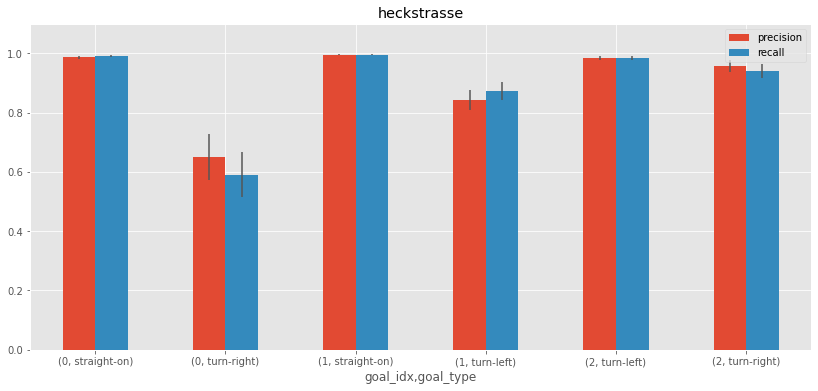

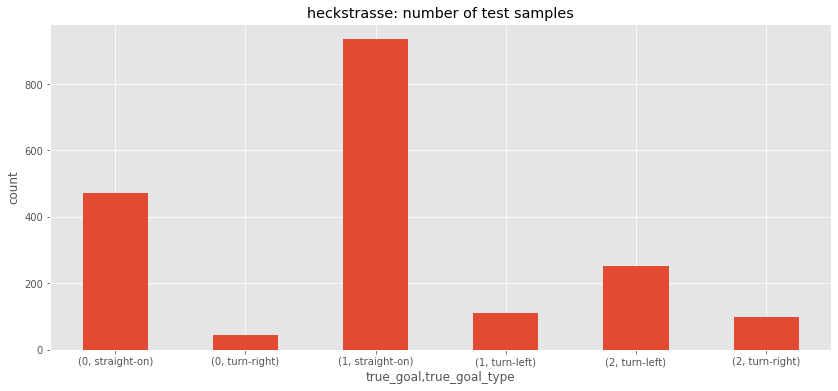

In [108]:
bar_plot_accuracy('heckstrasse', 'test')

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1766716: Outer ring must consist of ways but id -1755509 is of type node!
Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1766716: Outer ring must consist of ways but id -1755509 is of type node!
Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1766716: Outer ring must consist of ways but id -1755509 is of type node!


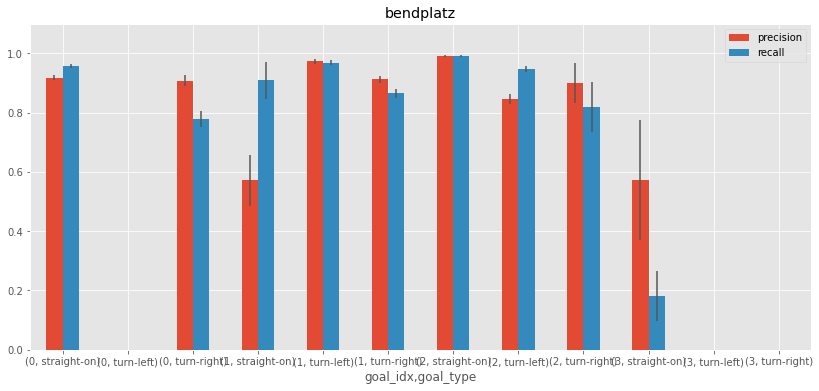

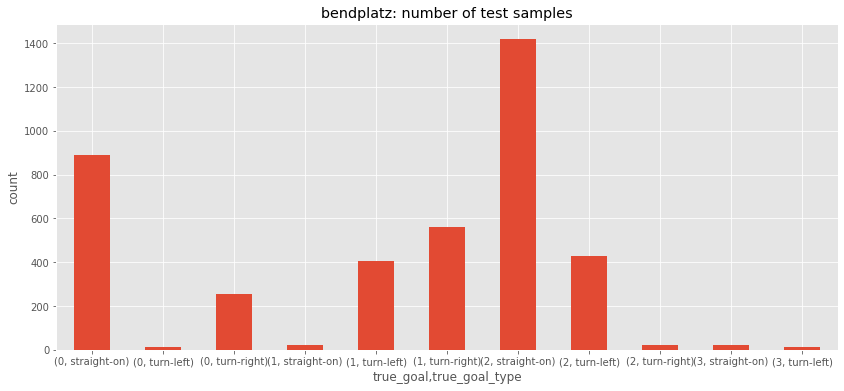

In [109]:
bar_plot_accuracy('bendplatz', 'test')

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1769638: Lanelet has not exactly one left border!
	- Error parsing primitive -1769638: Lanelet has not exactly one right border!
	- Error parsing primitive -1769619: Lanelet has not exactly one left border!
	- Error parsing primitive -1769619: Lanelet has not exactly one right border!
	- Error parsing primitive -1769583: Areas must have at least one outer border!
	- Error parsing primitive -1769582: Areas must have at least one outer border!
	- Error parsing primitive -1769569: Areas must have at least one outer border!
	- Error parsing primitive -1769541: Areas must have at least one outer border!
Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1769638: Lanelet has not exactly one left border!
	- Error parsing primitive -1769638: Lanelet has not exactly one right border!
	- Error parsing primitive -1769619: Lanelet has not exactly one left border!
	- Error parsing primitive -1769619: Lanelet ha

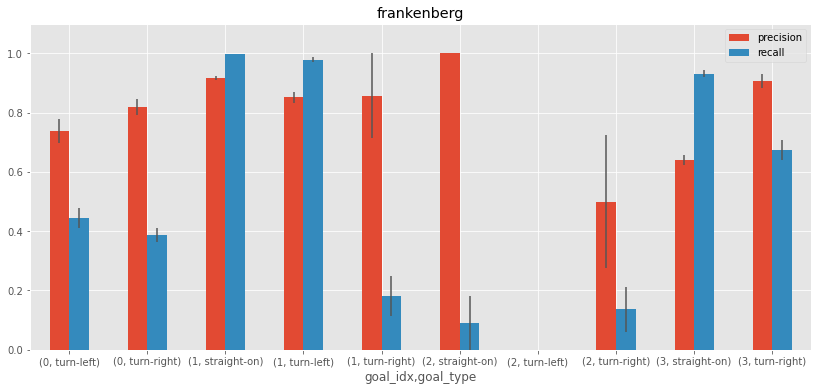

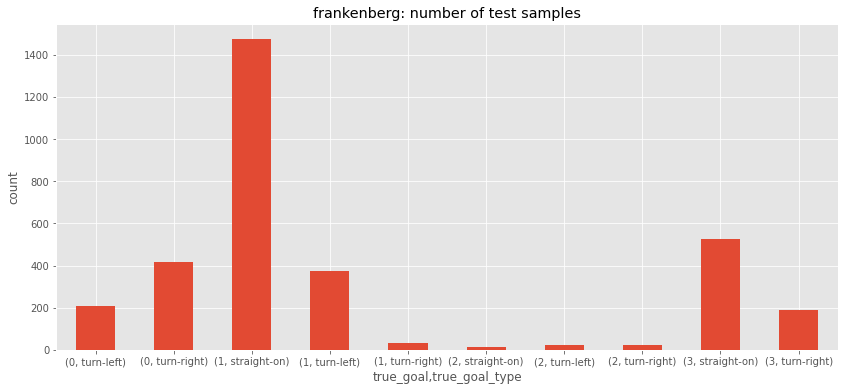

In [110]:
bar_plot_accuracy('frankenberg', 'test')

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	- Error parsing primitive -1770787: Areas must have exactly one outer ring!
Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1770767: Lanelet has not exactly one left border!
	- Error parsing primitive -1770767: Lanelet has not exactly one right border!
	- Error parsing primitive -1770766: Lanelet has not exactly one left border!
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770573
	- Error parsing primitive -1770787: Could not complete boundary around linestring -1770492
	

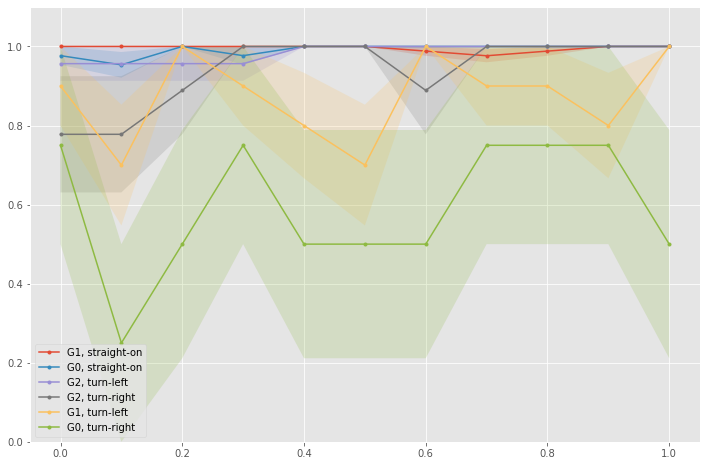

In [111]:
plot_accuracy('heckstrasse', 'test')

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1769638: Lanelet has not exactly one left border!
	- Error parsing primitive -1769638: Lanelet has not exactly one right border!
	- Error parsing primitive -1769619: Lanelet has not exactly one left border!
	- Error parsing primitive -1769619: Lanelet has not exactly one right border!
	- Error parsing primitive -1769583: Areas must have at least one outer border!
	- Error parsing primitive -1769582: Areas must have at least one outer border!
	- Error parsing primitive -1769569: Areas must have at least one outer border!
	- Error parsing primitive -1769541: Areas must have at least one outer border!
Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1769638: Lanelet has not exactly one left border!
	- Error parsing primitive -1769638: Lanelet has not exactly one right border!
	- Error parsing primitive -1769619: Lanelet has not exactly one left border!
	- Error parsing primitive -1769619: Lanelet ha

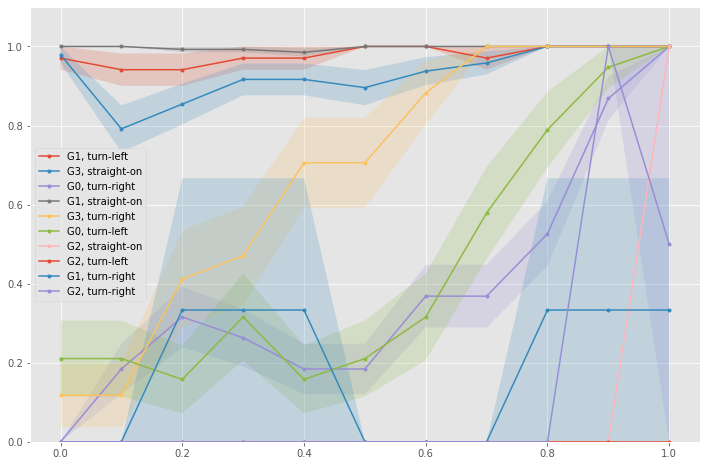

In [18]:
plot_accuracy('frankenberg', 'test')

In [49]:
precision.rename('precision', inplace=True)
precision.index.set_names(['goal_idx', 'goal_type'], inplace=True)
precision

goal_idx  goal_type  
0         straight-on    0.917293
          turn-right     0.916279
1         straight-on    0.555556
          turn-left      0.972840
          turn-right     0.911654
2         straight-on    0.990845
          turn-left      0.846473
          turn-right     0.894737
3         straight-on    0.571429
          turn-right     0.000000
Name: precision, dtype: float64

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1766716: Outer ring must consist of ways but id -1755509 is of type node!
Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1766716: Outer ring must consist of ways but id -1755509 is of type node!
Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1766716: Outer ring must consist of ways but id -1755509 is of type node!


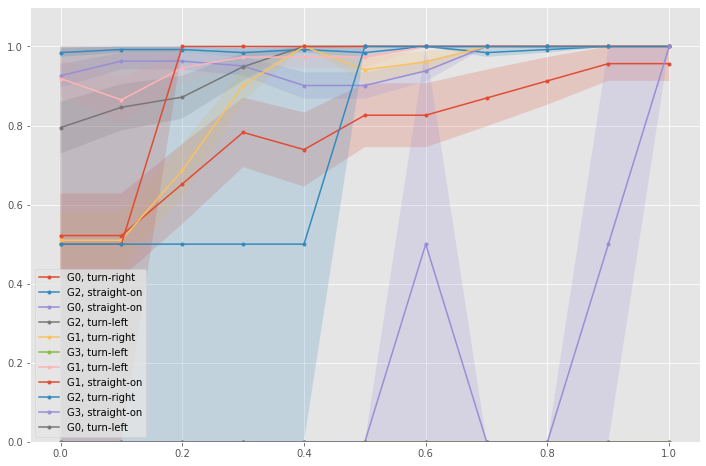

In [17]:
plot_accuracy('bendplatz', 'test')

Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1766716: Outer ring must consist of ways but id -1755509 is of type node!
Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1766716: Outer ring must consist of ways but id -1755509 is of type node!
Errors ocurred while parsing Lanelet Map:
	- Error parsing primitive -1766716: Outer ring must consist of ways but id -1755509 is of type node!


Text(0, 0.5, 'count')

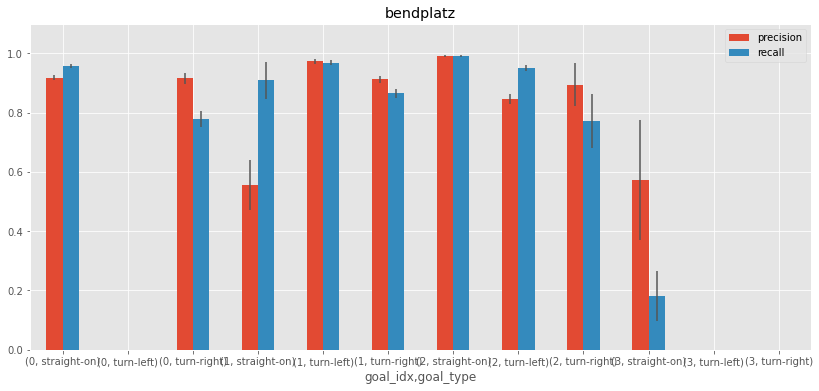

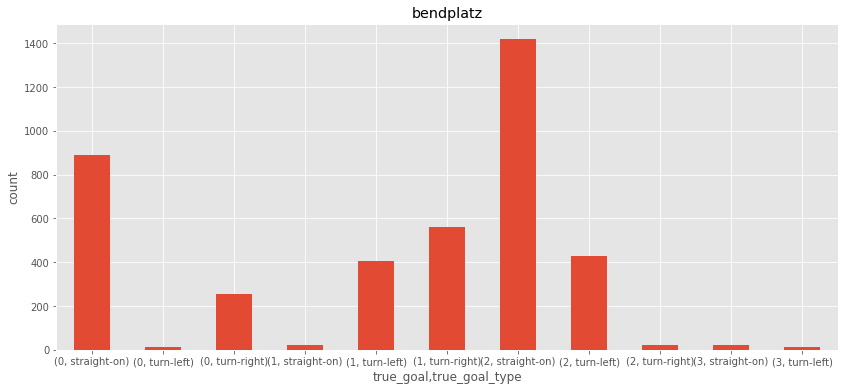

In [93]:
scenario_name = 'bendplatz'
dataset = get_dataset(scenario_name, dataset_name)
scenario = Scenario.load(get_scenario_config_dir() + scenario_name + '.json')


model = TrainedDecisionTrees.load(scenario_name)
unique_samples = model.batch_goal_probabilities(dataset)
unique_goals = unique_samples[['true_goal', 'true_goal_type']].drop_duplicates()
unique_samples['model_correct'] = (unique_samples['model_prediction']
                                   == unique_samples['true_goal'])
recall = unique_samples.groupby(['true_goal', 'true_goal_type']).model_correct.mean()

precision = unique_samples.groupby(['model_prediction', 'predicted_goal_type']
                                  ).model_correct.mean()

count = unique_samples.groupby(['true_goal', 'true_goal_type']
            ).model_correct.count()


recall_sem = unique_samples.groupby(['true_goal', 'true_goal_type']
            ).model_correct.std() / np.sqrt(count)

pred_count = unique_samples.groupby(['model_prediction', 'predicted_goal_type']
        ).model_correct.count()
precision_sem = unique_samples.groupby(['model_prediction', 'predicted_goal_type']
        ).model_correct.std() / np.sqrt(pred_count)


precision.rename('precision', inplace=True)
precision.index.set_names(['goal_idx', 'goal_type'], inplace=True)
recall.rename('recall', inplace=True)
recall.index.set_names(['goal_idx', 'goal_type'], inplace=True)
stats = precision.to_frame().join(recall, how='outer')

recall_sem.rename('recall_sem', inplace=True)
recall_sem.index.set_names(['goal_idx', 'goal_type'], inplace=True)
precision_sem.rename('precision_sem', inplace=True)
precision_sem.index.set_names(['goal_idx', 'goal_type'], inplace=True)
sems = precision_sem.to_frame().join(recall_sem, how='outer')

stats.plot.bar(rot=0, figsize=(14, 6), yerr=[sems.precision_sem, sems.recall_sem])
plt.ylim([0, 1.1])
plt.title(scenario_name)

plt.figure()
count.plot.bar(rot=0, figsize=(14, 6))
plt.title(scenario_name)
plt.ylabel('count')

In [98]:
unique_samples.loc[(unique_samples.true_goal==0) 
                   & (unique_samples.true_goal_type=='turn-left')]

,episode,agent_id,frame_id,true_goal,true_goal_type,fraction_observed,model_prediction,predicted_goal_type,model_probs,max_probs,min_probs,model_entropy,model_entropy_norm,model_correct
472,10,336,23250,0,turn-left,0.0,1,straight-on,0.783827,0.783827,0.030891,0.610694,0.555878,False
475,10,336,23385,0,turn-left,0.1,1,straight-on,0.623759,0.623759,0.029943,0.766697,0.697878,False
478,10,336,23520,0,turn-left,0.2,1,straight-on,0.623759,0.623759,0.029943,0.766697,0.697878,False
481,10,336,23655,0,turn-left,0.3,1,straight-on,0.623759,0.623759,0.029943,0.766697,0.697878,False
484,10,336,23790,0,turn-left,0.4,1,straight-on,0.623759,0.623759,0.029943,0.766697,0.697878,False
487,10,336,23925,0,turn-left,0.5,1,straight-on,0.623759,0.623759,0.029943,0.766697,0.697878,False
490,10,336,24060,0,turn-left,0.6,1,straight-on,0.785839,0.785839,0.037724,0.619111,0.563539,False
493,10,336,24195,0,turn-left,0.7,1,straight-on,0.785839,0.785839,0.037724,0.619111,0.563539,False
496,10,336,24330,0,turn-left,0.8,1,straight-on,0.785839,0.785839,0.037724,0.619111,0.563539,False
499,10,336,24465,0,turn-left,0.9,1,straight-on,0.785839,0.785839,0.037724,0.619111,0.563539,False


In [94]:
stats

precision    recall
goal_idx goal_type                       
0        straight-on   0.917293  0.958474
         turn-left          NaN  0.000000
         turn-right    0.916279  0.778656
1        straight-on   0.555556  0.909091
         turn-left     0.972840  0.968059
         turn-right    0.911654  0.864528
2        straight-on   0.990845  0.991543
         turn-left     0.846473  0.951049
         turn-right    0.894737  0.772727
3        straight-on   0.571429  0.181818
         turn-left          NaN  0.000000
         turn-right    0.000000       NaN

In [88]:
recall_sem

goal_idx  goal_type  
0         straight-on    0.006687
          turn-left      0.000000
          turn-right     0.026152
1         straight-on    0.062733
          turn-left      0.008727
          turn-right     0.014462
2         straight-on    0.002432
          turn-left      0.010429
          turn-right     0.091449
3         straight-on    0.084165
          turn-left      0.000000
Name: recall_sem, dtype: float64

In [92]:
sems

precision_sem  recall_sem
goal_idx goal_type                             
0        straight-on       0.009032    0.006687
         turn-right        0.018933    0.026152
1        straight-on       0.083992    0.062733
         turn-left         0.008087    0.008727
         turn-right        0.012316    0.014462
2        straight-on       0.002528    0.002432
         turn-left         0.016437    0.010429
         turn-right        0.072335    0.091449
3        straight-on       0.202031    0.084165
         turn-right             NaN         NaN